In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import csv
import random
import numpy as np

import time
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

from tensorflow.keras import backend as K

2025-03-20 18:47:13.343412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 18:47:13.343456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 18:47:13.344078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 18:47:13.348362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 18:47:14.054744: W tensorflow/compiler/tf2

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Definição do diretório de saída
output_dir = "UNet DICE 5-fold model"
os.makedirs(output_dir, exist_ok=True)  # Garante que a pasta existe

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:18<00:00, 44.22it/s]


In [4]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [5]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))


In [6]:
def unet():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
     
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
     
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
     
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)
    
     
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)
    
     
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
     
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)
    
     
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss,metrics=[
            'accuracy', 
            tf.keras.metrics.Recall(name='recall'), 
            tf.keras.metrics.Precision(name='precision'),
            f1_score,
            tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
        ])

    return model

In [7]:
def small_unet():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Encoder (reduzido)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)

    # Decoder
    u5 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c3])
    u5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    
    u6 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    u6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    
    u7 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    u7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u7)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
        loss=dice_loss,  # Usando Dice Loss para lidar com o desbalanceamento
        metrics=[
            'accuracy', 
            tf.keras.metrics.Recall(name='recall'), 
            tf.keras.metrics.Precision(name='precision'),
            f1_score,
            tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
        ]
    )

    return model

In [8]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 1

for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i < (fold-1):
        continue
    
    
    print("Fold: " + str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = unet()
    
    
    checkpoint_filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    start_time = time.time()
    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=150, callbacks=callbacks)
    end_time = time.time()
    training_time = end_time - start_time

     # Salvando o tempo de treinamento
    with open(os.path.join(output_dir, 'training_time.txt'), 'a') as f:
        f.write(f'Fold {fold}: {training_time:.2f} segundos\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    with open(os.path.join(output_dir, f'loss_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Epoch", "Loss", "Validation Loss"])
        for epoch, (l, vl) in enumerate(zip(loss, val_loss), start=1):
            writer.writerow([epoch, l, vl])
            
     # Plotando e salvando a figura
    plt.figure()
    plt.plot(loss, 'r', label='Training loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'loss_plot_fold{fold}.png'))
    plt.close()


    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])

        
    del model 

    tf.keras.backend.clear_session()

    fold+=1
    
# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

Fold: 1


2025-03-20 18:47:34.791666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-20 18:47:34.824282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-20 18:47:34.824327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-20 18:47:34.825953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-20 18:47:34.825983: I external/local_xla/xla/stream_executor

Epoch 1/150


2025-03-20 18:47:37.970796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-20 18:47:38.330074: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-20 18:47:41.719718: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6042d43690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-20 18:47:41.719747: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-20 18:47:41.735857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742507261.833031  544295 device_compiler.h:186] Compiled cluster using XLA!  T

42/42 [==============================] - ETA: 0s - loss: 0.9975 - accuracy: 0.7301 - recall: 0.9402 - precision: 0.0021 - f1_score: 0.0045 - IoU: 0.5027
Epoch 1: val_f1_score improved from -inf to 0.00262, saving model to UNet DICE 5-fold model/model_1fold.keras
42/42 [==============================] - 46s 620ms/step - loss: 0.9975 - accuracy: 0.7301 - recall: 0.9402 - precision: 0.0021 - f1_score: 0.0045 - IoU: 0.5027 - val_loss: 0.9980 - val_accuracy: 0.5137 - val_recall: 1.0000 - val_precision: 0.0014 - val_f1_score: 0.0026 - val_IoU: 0.4667
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9957 - accuracy: 0.9075 - recall: 0.9759 - precision: 0.0065 - f1_score: 0.0234 - IoU: 0.5055
Epoch 2: val_f1_score improved from 0.00262 to 0.05756, saving model to UNet DICE 5-fold model/model_1fold.keras
42/42 [==============================] - 9s 224ms/step - loss: 0.9957 - accuracy: 0.9075 - recall: 0.9759 - precision: 0.0065 - f1_score: 0.0234 - IoU: 0.5055 - val_loss: 

/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold: 2
Epoch 1/150


2025-03-20 19:12:07.803986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - ETA: 0s - loss: 0.9977 - accuracy: 0.6636 - recall: 0.9369 - precision: 0.0017 - f1_score: 0.0040 - IoU: 0.5034
Epoch 1: val_f1_score improved from -inf to 0.00228, saving model to UNet DICE 5-fold model/model_2fold.keras
42/42 [==============================] - 14s 236ms/step - loss: 0.9977 - accuracy: 0.6636 - recall: 0.9369 - precision: 0.0017 - f1_score: 0.0040 - IoU: 0.5034 - val_loss: 0.9981 - val_accuracy: 0.4535 - val_recall: 1.0000 - val_precision: 0.0012 - val_f1_score: 0.0023 - val_IoU: 0.4050
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.8752 - recall: 0.9937 - precision: 0.0049 - f1_score: 0.0155 - IoU: 0.5212
Epoch 2: val_f1_score improved from 0.00228 to 0.01237, saving model to UNet DICE 5-fold model/model_2fold.keras
42/42 [==============================] - 9s 224ms/step - loss: 0.9963 - accuracy: 0.8752 - recall: 0.9937 - precision: 0.0049 - f1_score: 0.0155 - IoU: 0.5212 - val_loss: 

2025-03-20 19:36:02.515549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - ETA: 0s - loss: 0.9973 - accuracy: 0.7235 - recall: 0.9890 - precision: 0.0022 - f1_score: 0.0048 - IoU: 0.4997
Epoch 1: val_f1_score improved from -inf to 0.00472, saving model to UNet DICE 5-fold model/model_3fold.keras
42/42 [==============================] - 14s 242ms/step - loss: 0.9973 - accuracy: 0.7235 - recall: 0.9890 - precision: 0.0022 - f1_score: 0.0048 - IoU: 0.4997 - val_loss: 0.9975 - val_accuracy: 0.7537 - val_recall: 0.9978 - val_precision: 0.0025 - val_f1_score: 0.0047 - val_IoU: 0.5069
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.9337 - recall: 0.9879 - precision: 0.0093 - f1_score: 0.0415 - IoU: 0.4999
Epoch 2: val_f1_score did not improve from 0.00472
42/42 [==============================] - 9s 225ms/step - loss: 0.9945 - accuracy: 0.9337 - recall: 0.9879 - precision: 0.0093 - f1_score: 0.0415 - IoU: 0.4999 - val_loss: 0.9999 - val_accuracy: 0.9964 - val_recall: 0.0071 - val_preci

/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold: 4
Epoch 1/150


2025-03-20 20:00:08.636867: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - ETA: 0s - loss: 0.9976 - accuracy: 0.6948 - recall: 0.8829 - precision: 0.0018 - f1_score: 0.0041 - IoU: 0.5082
Epoch 1: val_f1_score improved from -inf to 0.00199, saving model to UNet DICE 5-fold model/model_4fold.keras
42/42 [==============================] - 29s 606ms/step - loss: 0.9976 - accuracy: 0.6948 - recall: 0.8829 - precision: 0.0018 - f1_score: 0.0041 - IoU: 0.5082 - val_loss: 0.9983 - val_accuracy: 0.4490 - val_recall: 1.0000 - val_precision: 0.0011 - val_f1_score: 0.0020 - val_IoU: 0.4017
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.8596 - recall: 0.9850 - precision: 0.0045 - f1_score: 0.0138 - IoU: 0.5183
Epoch 2: val_f1_score improved from 0.00199 to 0.00383, saving model to UNet DICE 5-fold model/model_4fold.keras
42/42 [==============================] - 9s 225ms/step - loss: 0.9958 - accuracy: 0.8596 - recall: 0.9850 - precision: 0.0045 - f1_score: 0.0138 - IoU: 0.5183 - val_loss: 

2025-03-20 20:23:56.663574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - ETA: 0s - loss: 0.9975 - accuracy: 0.7379 - recall: 0.8787 - precision: 0.0021 - f1_score: 0.0046 - IoU: 0.5036
Epoch 1: val_f1_score improved from -inf to 0.00234, saving model to UNet DICE 5-fold model/model_5fold.keras
42/42 [==============================] - 14s 236ms/step - loss: 0.9975 - accuracy: 0.7379 - recall: 0.8787 - precision: 0.0021 - f1_score: 0.0046 - IoU: 0.5036 - val_loss: 0.9982 - val_accuracy: 0.5246 - val_recall: 1.0000 - val_precision: 0.0013 - val_f1_score: 0.0023 - val_IoU: 0.4515
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9956 - accuracy: 0.8721 - recall: 0.9854 - precision: 0.0049 - f1_score: 0.0181 - IoU: 0.5080
Epoch 2: val_f1_score did not improve from 0.00234
42/42 [==============================] - 9s 219ms/step - loss: 0.9956 - accuracy: 0.8721 - recall: 0.9854 - precision: 0.0049 - f1_score: 0.0181 - IoU: 0.5080 - val_loss: 1.0000 - val_accuracy: 0.9829 - val_recall: 0.0000e+00 - val_p

In [9]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

fold = 1
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    model_filepath = filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    model = tf.keras.models.load_model(model_filepath)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])


    fold += 1

# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.01s/it]

Métricas salvas com sucesso na pasta: UNet DICE 5-fold model


In [10]:
print("Accuracy: "+ str(np.mean(acc_total)*100) + " +- " + str(np.std(acc_total)*100))
print("Jaccard: "+ str(np.mean(jacc_total)*100) + " +- " + str(np.std(jacc_total)*100))
print("Dice: "+ str(np.mean(f1_total)*100) + " +- " + str(np.std(f1_total)*100))
print("Precision: "+ str(np.mean(prec_total)*100) + " +- " + str(np.std(prec_total)*100))
print("Recall: "+ str(np.mean(rec_total)*100) + " +- " + str(np.std(rec_total)*100))

Accuracy: 99.99743440941864 +- 0.0007449498501694777
Jaccard: 94.38134972213294 +- 0.5537219633089292
Dice: 96.82371020317078 +- 0.26512821204960346
Precision: 97.5830463754592 +- 0.4967110853948472
Recall: 96.6234988880705 +- 0.9367804907462047


In [11]:
best_fold = 2
best_model_filepath = filepath = os.path.join(output_dir, f'model_{best_fold}fold.keras')
best_model = tf.keras.models.load_model(best_model_filepath)

In [12]:
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (best_fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

1/1 [==============================] - 0s 138ms/step


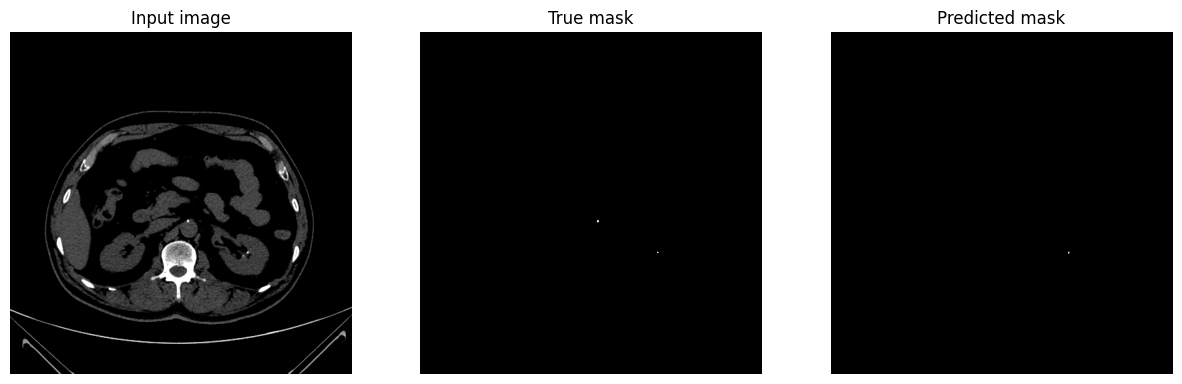

Accuracy: 0.9999618530273438
Jaccard: 0.2857142857142857
Dice: 0.4444444444444445
Precision: 0.8
Recall: 0.3076923076923077


In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  
#i = random.randint(0, len(X_val))
i = 155
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))